<a href="https://colab.research.google.com/github/yasmine-houri/Word_embeddings/blob/main/Code_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word embeddings

This is an introduction to word embeddings, as premliminary work for my PhD proposal on the following subject:  

**Detection of gender bias in the textual representations of French administrative elites, using word embeddings**  

under the supervision of **Jean-Philippe Cointet** (data scientist at médialab, Sciences Po, Paris, France), and **Achim Edelmann** (sociologist at médialab, Sciences Po, Paris, France)  
Feel free to email me at yasmine.houri@ensae.fr if you have any questions.  

This notebook is freely adapted from https://www.tensorflow.org/text/guide/word_embeddings and https://notebook.community/henchc/Rediscovering-Text-as-Data/11-Word-Embeddings/01-Word-Embeddings. All due credits belong to the authors of these two pages. I will be using data from: https://txtlab.org/2016/01/txtlab450-a-data-set-of-multilingual-novels-for-teaching-and-research/ .

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, you will look at three strategies for doing so.

### One-hot encodings

As a first idea, you might "one-hot" encode each word in your vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, you will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, you could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine you have 10,000 words in the vocabulary. To one-hot encode each word, you would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This approach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, you can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from datascience import *
import numpy as np
from scipy.spatial.distance import cosine
import gensim
import nltk
from string import punctuation
import pandas as pd

### Load the Dataset

In [2]:
url = "https://raw.githubusercontent.com/yasmine-houri/Word_embeddings/main/"

metadata_tb = pd.read_csv(url+'Data/2_txtlab_Novel150.csv').drop('Unnamed: 0', axis=1)

fiction_path = url+'Data/'

novel_list = []

import requests
# Iterate through filenames in metadata table
for filename in metadata_tb['filename']:
    
    # Read in novel text as single string, make lowercase
    url = fiction_path + filename
    novel = requests.get(url)
    novel.encoding = 'utf-8-sig'
    
    # Add novel text as single string to master list
    novel_list.append(novel.text)


## Text preprocessing

In [3]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

def fast_tokenize(text):
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in text if char not in punctuation])
    
    # Split text over whitespace into list of words
    tokens = no_punct.split()
    
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# import random
# randomlist = []
# for i in range(0,50):
#   n = random.randint(0,len(novel_list)-1)
#   randomlist.append(n)
# randomlist= tuple(randomlist)

# short_list = [novel_list[i] for i in randomlist]  

In [5]:
sentences = [sentence for novel in novel_list for sentence in sent_tokenize(novel)]

In [6]:
words_by_sentence = [fast_tokenize(sentence.lower()) for sentence in sentences]

In [7]:
words_by_sentence = [sentence for sentence in words_by_sentence if sentence != []]

## Train the model

Word2Vec is the most prominent word embedding algorithm. Word embedding generally attempts to identify semantic relationships between words by observing them in context.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts. This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of Word2Vec are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. Skip-Gram takes a word of interest as its input (e.g. "me") and tries to learn how to predict its context words ("Call","Ishmael"). CBOW does the opposite, taking the context words ("Call","Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

Word2Vec Features  

* `size`: Number of dimensions for word embedding model
* `window`: Number of context words to observe in each direction
* `min_count`: Minimum frequency for words included in model
* `sg` (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram
* `alpha`: Learning rate (initial); prevents model from over-correcting, enables finer tuning
* `iterations`: Number of passes through dataset
* `batch_words`: Number of words to sample from data during each pass  

Note: cell below uses default value for each argument

In [8]:
model = gensim.models.Word2Vec(words_by_sentence, size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=15, batch_words=10000)

## Embeddings

In [24]:
print("Diplomate (femme/homme): ", model.similarity('femme','diplomate'), model.similarity('homme','diplomate'))
print("Cadre (femme/homme): ", model.similarity('femme','cadre'), model.similarity('homme','cadre'))
print("Artiste (femme/homme): ", model.similarity('femme','artiste'), model.similarity('homme','artiste'))

Diplomate (femme/homme):  0.182798 0.512745
Cadre (femme/homme):  -0.0930099 0.132754
Artiste (femme/homme):  0.349249 0.661657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
model.most_similar(positive=['femme', 'directeur'], negative=['homme'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('gouvernante', 0.6177148222923279),
 ('réclamation', 0.59853196144104),
 ('cuisinière', 0.5964016914367676),
 ('commission', 0.5833282470703125),
 ('ordonnance', 0.579981803894043),
 ('concierge', 0.5760716795921326),
 ('présentation', 0.574821949005127),
 ('maîtresse', 0.5737243890762329),
 ('patronne', 0.5713073015213013),
 ('nomination', 0.5663789510726929)]

## Visualisations

In [26]:
model.most_similar('femme')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('fille', 0.9210683107376099),
 ('demoiselle', 0.7993378639221191),
 ('maîtresse', 0.77012038230896),
 ('comédienne', 0.7508684992790222),
 ('soeur', 0.7368858456611633),
 ('cousine', 0.7354142069816589),
 ('dame', 0.7344369888305664),
 ('mère', 0.7341681718826294),
 ('actrice', 0.7337675094604492),
 ('créature', 0.7265391945838928)]

In [14]:
her_tokens = [token for token,weight in model.most_similar(['femme','homme'], topn=30)]
vectors = [model[word] for word in her_tokens]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [15]:
from sklearn.metrics import pairwise
dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')
from sklearn.manifold import MDS
mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)

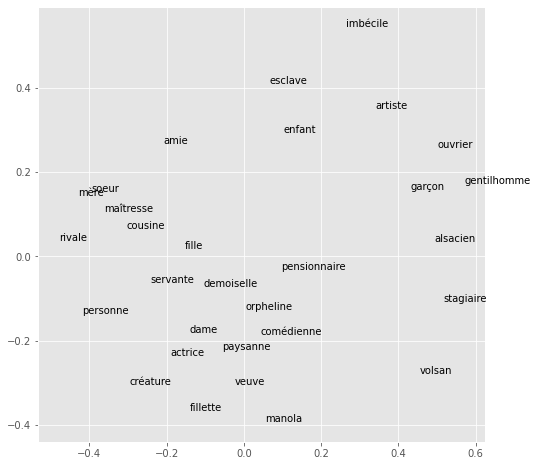

In [27]:
%matplotlib inline
_, ax = plt.subplots(figsize=(8,8))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(her_tokens[i], ((embeddings[i,0], embeddings[i,1])))
# plt.plot([-0.4, 0.6], [-0.4, 0.25], 'k-')